# **Binned invariant mass fit with flarefly**

The goal of this tutorial is to provide an example of invariant mass fit using the package [flarefly](https://flarefly.github.io/flarefly/index.html).

This tutorial is based on the measurement of the invariant mass of the $\mathrm{B^{0}}$ meson, trough its two-body decay channel $\mathrm{B^{0}} \rightarrow \mathrm{D^{-}} +\mathrm{\pi^{+}}$, in the transverse-momentum interval $0 \leqslant p_{\mathrm{T}} \leqslant 50$ GeV/$c$. The data were Monte Carlo simulated by ALICE (where the decay channel of interest is forced) and correspond to 5 million minimum-bias pp collisions at $\sqrt{s}$ = 900 GeV. In this data sample about $12\,000$ $\mathrm{B^{0}}$ candidates were reconstructed.

## **Prerequisites**

The following packages are needed to follow this tutorial and in general to use _flarefly_:

- [_uproot_](https://github.com/scikit-hep/uproot) is a reader and a writer of the ROOT file data format and is used to cast blocks of data from the ROOT file as Numpy arrays.

- [_zfit_](https://github.com/zfit) is a highly scalable and customizable model manipulation and fitting library. It uses [_TensorFlow_](https://www.tensorflow.org/) as its computational backend and is optimised for simple and direct manipulation of probability density functions.


In [ ]:
%%capture
!pip install tensorflow
!pip install zfit
!pip install git+https://github.com/flarefly/flarefly.git@dev
!pip install uproot

## **File download**

In [ ]:
%%capture
!curl -L https://github.com/flarefly/flarefly/raw/main/tutorials/histos_b0.root --output file.root

## **Required python packages**

The packages required for the tutorial are imported in the following.

In [ ]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import uproot
from flarefly.data_handler import DataHandler
from flarefly.fitter import F2MassFitter

## **Prepare data | DataHandler instance**

The data one aims at fitting are drawn from the histogram *hist_mass_bzero_pt0_50* contained in *file.root* downloaded earlier.

*flarefly* allows for a simple handling of the data by calling a *DataHandler* instance that shall take care of adapting the input to our fitter class.

**NB**: In our case the input data are _binned_ but *flarefly* can also handle _unbinned_ data.

In [ ]:
data = DataHandler(data="file.root",
                   var_name=r"$M_\mathrm{D^{-}\pi^{+}}$ (GeV/$c^{2}$)",
                   histoname="hist_mass_bzero_pt0_50")

## **Prepare fitter | F2MassFitter instance**

Once data are prepared, one still needs to configure the fitter:

1. Define probability density functions (PDFs) for signal and background
2. Define a F2MassFitter instance
3. Initialize fit parameters

### **1. Define PDFs**

*flarefly* is based on *zfit*, itself optimised for a direct manipulation of probability density functions. Hence the need to define PDFs for signal and for background.

**NB**: *flarefly* allows one to perform multi-fits with several signal and/or background PDFs. That's why one works with PDFs **lists**. In this sense, every PDF is associated to an index (i.e. its position in the list). This index will be required later while configuring the fitter.

In [ ]:
# define PDFs lists
signal_pdfs = ["gaussian"]
background_pdfs = ["expo"]

# define the ids
gaussian_id = 0 # because signal_pdfs[gaussian_id] = "gaussian"
expo_id = 0     # because background_pdfs[expo_id] = "expo"

### **2. Define a F2MassFitter instance**



In [ ]:
fitter = F2MassFitter(data_handler=data,
                      name_signal_pdf=signal_pdfs,
                      name_background_pdf=background_pdfs,
                      name=f"{background_pdfs[expo_id]}_{signal_pdfs[gaussian_id]}")

**NB**: the name of the *F2MassFitter* instance is optional yet needed in case of multiple fitters defined in the same script (each fitter shall possess a unique name).

### **3. Initialize fit parameters**

The naming convention of the fit parameters is adapted to *flarefly* environment:

- First of all, one can access the parameters names either via the [_zfit_ documentation](https://zfit.readthedocs.io/en/latest/user_api/zfit.pdf.html) (for the PDFs defined there) or in the [_custom_pdfs_](https://flarefly.github.io/flarefly/custom_pdfs.html) class (for the PDFs specific to *flarefly*).
- Then, two subtelties arise:
  - Here *mass* takes a specific place among the fit parameters (as *flarefly* is thought for invariant mass fit) so there is a dedicated method for its initialization: _set_particle_mass_. \\
  Hence the _mu_ parameter (or _m_ for cauchy PDF) is handled via this dedicated method, where one can (among other possibilities) use the PDG code of the particle (511 for $\mathrm{B^0}$).
  - The normalization factor attached to each PDF, named _frac_ (for fraction of this PDF with respect to the total PDF) can also be initialized.

Otherwise, the other parameters of the PDFs (as _sigma_ for the gaussian PDF) keep the same name.

**NB**: one can limit the value of a parameter to a given interval or fix a given parameter, see [documentation](https://flarefly.github.io/flarefly/fitter.html#flarefly.fitter.F2MassFitter.set_signal_initpar).

In [ ]:
fitter.set_particle_mass(gaussian_id, pdg_id=511)
fitter.set_signal_initpar(gaussian_id, "frac", 0.3, limits=[0.2, 0.4])
fitter.set_signal_initpar(gaussian_id, "sigma", 0.010)

fitter.set_background_initpar(expo_id, "lam", -1.5)

## **The actual (one-liner) mass fit**

The method _mass_zfit_ builds a total PDF (from the signal and background ones) to fit data using _zfit_ library.

In [ ]:
fitter.mass_zfit()

I MnSeedGenerator Initial state: FCN =       1512.482496 Edm =       5.209614617 NCalls =     17
I MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 415.2520176
  Edm           : 45.99236745
  Internal parameters:
  7.450580486e-08
     -1.566200821
     -1.570333484
         -1.5e-06
  Internal gradient  :
     -69.37062467
      4880997.344
      818257.4754
     -72057645.28
  Internal covariance matrix:
    0.011462677              0              0              0
              0  8.5890073e-13              0              0
              0              0  8.3275109e-11              0
              0              0              0  1.0128218e-14
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 680
I VariableMetricBuilder    0 - FCN =       415.2520176 Edm =       45.99236745 NCalls =     40
I VariableMetricBuilder    1 - FCN =       378.0912838 Edm =       6.791539108 NCalls =     50
I VariableMetricBuilder    2 - FCN =       372.8407971 E

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fd8cb6774c0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fd8cb677b20>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00038 │ 372.6224    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                           value  (rounded)        hesse    at limit
---------------------------  ------------------  -----------  ----------
expo_gaussian_frac_signal0             0.321059  +/-  0.0089       False
expo_gaussian_mu_signal0                5.27251  +/-  0.0014       False
expo_gaussian_sigma_signal0           0.0478494  +/-  0.0015       False
expo_gaussian_lam_bkg0                 -1.06745  +/-   0.0

**NB**: one can directly store the fit result in a variable via *fitres = fitter.mass_zfit()* or call it later on as follows: *fitres = fitter.get_fit_result()*.

## **Draw plots**

*flarefly* provides plot utils to draw:
- the invariant mass fit of the total PDF, along with the signal PDF and background PDF. There is the possibility to plot _extra_info_ such as parameters, signal and background derived quantities;
- the raw residuals of the fit: (data_value - bkg_model_value);
- the standardized residuals of the fit: (data_value - bkg_model_value)/ sigma_data .

[    5, 5.006) 92  │███████████████████                                      │
[5.006, 5.012) 74  │███████████████▎                                         │
[5.012, 5.018) 94  │███████████████████▍                                     │
[5.018, 5.024) 95  │███████████████████▋                                     │
[5.024,  5.03) 83  │█████████████████▏                                       │
[ 5.03, 5.036) 111 │██████████████████████▉                                  │
[5.036, 5.042) 71  │██████████████▋                                          │
[5.042, 5.048) 99  │████████████████████▌                                    │
[5.048, 5.054) 82  │█████████████████                                        │
[5.054,  5.06) 91  │██████████████████▊                                      │
[ 5.06, 5.066) 103 │█████████████████████▎                                   │
[5.066, 5.072) 75  │███████████████▌                                         │
[5.072, 5.078) 93  │███████████████████▎            

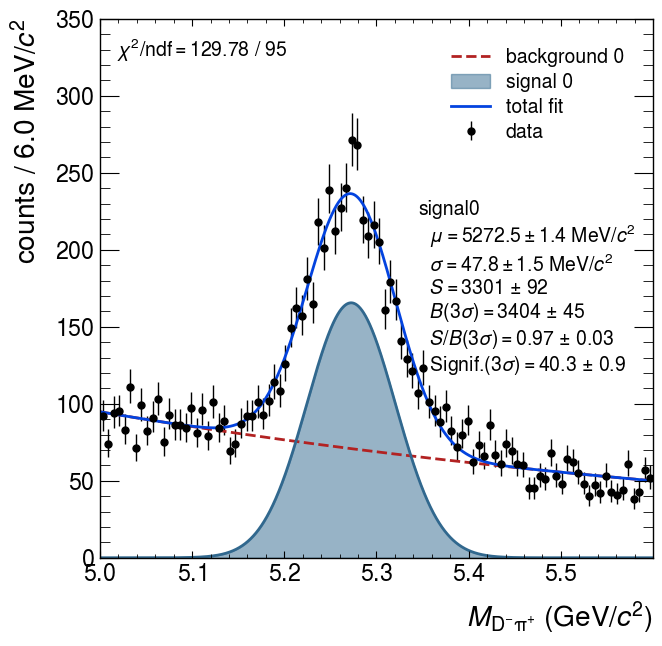

In [ ]:
# plot the fit result with display options
plot_mass_fit = fitter.plot_mass_fit(style="ATLAS",
                    show_extra_info=True,
                    extra_info_loc=['upper left', 'center right'])

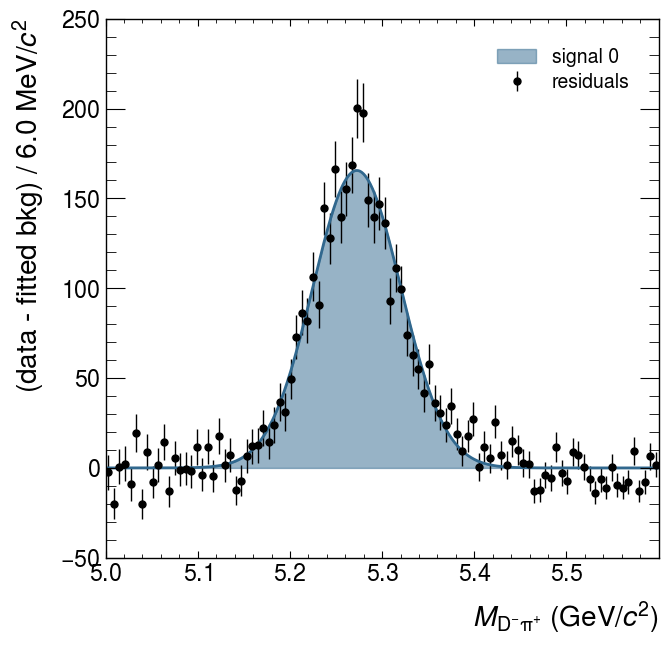

In [ ]:
plot_raw_residuals = fitter.plot_raw_residuals(style="ATLAS")

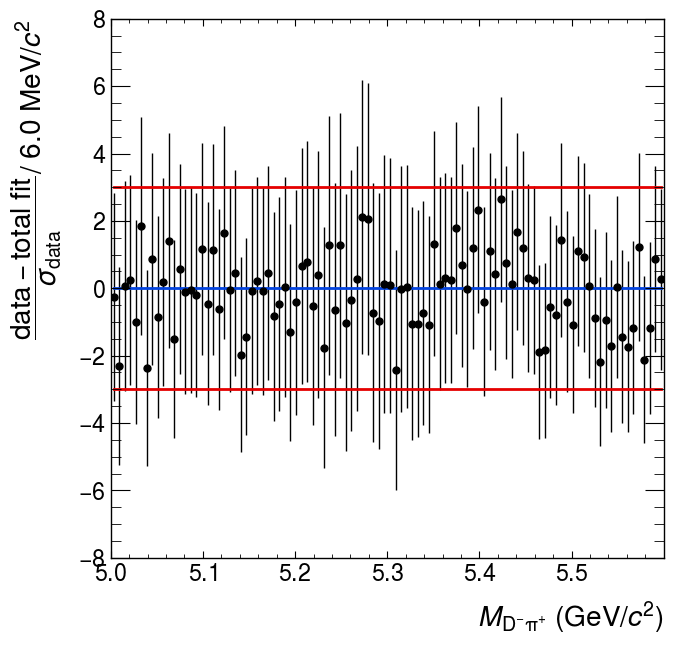

In [ ]:
plot_std_residuals = fitter.plot_std_residuals(style="ATLAS")

## **Get information on fit results**

Once the mass fit is performed, one can access fit parameters value and uncertainty via _F2MassFitter_ instance.

In [ ]:
frac_value, frac_error = fitter.get_signal_parameter(gaussian_id, "frac")
sigma_value, sigma_error = fitter.get_signal_parameter(gaussian_id, "sigma")

lambda_value, lambda_error = fitter.get_background_parameter(expo_id, "lam")

print(f"Signal fraction = {frac_value:.4f} +- {frac_error:.4f}")
print(f"sigma = {sigma_value:.4f} +- {sigma_error:.4f} GeV/c^2")
print(f"lambda = {lambda_value:.4f} +- {lambda_error:.4f} c^2/Gev")

Signal fraction = 0.3211 +- 0.0089
sigma = 0.0478 +- 0.0015 GeV/c^2
lambda = -1.0674 +- 0.0719 c^2/Gev


In HEP, one is also and foremost interested in accessing the raw yield of the studied particle. There is also a dedicated method for that.

In [ ]:
raw_yield, raw_yield_error = fitter.get_raw_yield(gaussian_id)

print(f"B0 raw yield for 0 < pT < 50 GeV/c :{raw_yield:.0f} +- {raw_yield_error:.0f}")

B0 raw yield for 0 < pT < 50 GeV/c :3309 +- 92


## **Bonus: Export information to .root file**

One could be interested in saving the data and PDFs curves in a _.root_ file. If so, the method _dump_to_root_ can be used.

In [ ]:
fitter.dump_to_root(filename="output.root")